# Initialschätzung von Kurswechselpositionen eines Segelboots auf einer Karte anhang con Wind, Start und Zielpunkt

## Motivation

Ziel dieser Semester abschließenden schriftlichen Ausarbeitung im Fach "Maschine Learning" an der Fachhochschule Südwestfalen ist das Generieren einer Heatmap von Kurswechselpositionen eines Segelbootes zu einer Karte abhängig von Wind und der Zielpostion. Dies soll das Finden einer guten Route vereinfachen, indem die Qualität einer ersten Route, die danach über ein Quotientenabstiegsverfahren optimiert werden soll verbessern. Da ein solches Quotientenabstiegsverfahren sehr gerne in einem Lokalen minimum festhängt, müssen mehrere routen gefunden und optimiert werden. Hier soll untersucht werden, ob dies durch eine Ersteinschätzung der Lage durch KI verbessert werden kann.

Eingesetzt werden soll die so erstellte KI in dem Segelroboter des [Sailing Team Darmstadt e.V.](https://www.st-darmstadt.de/) Einer Hochschulgruppe an der TU-Darmstadt welche den ["roBOOTer"](https://www.st-darmstadt.de/ueber-uns/boote/prototyp-ii/) ein vollautonomes Segelboot welches eines Tages den Atlantik überqueren soll. [Eine technische Herausforderung welche zuerst von einem norwegischen Team erfolgreich abgeschlossen wurde](https://www.microtransat.org/).

## Inhaltsverzeichnis

1. Einleitung

    1.1. Situation
    
    1.2. Vorgehen zur unterstützenden KI
        1.2.1. Eingaben und Ausgeben
2. Vorbereitungen

    2.1. Imports
    
    2.2. Parameter und Settings
    
3. Szenarien und Routen Generieren

4. Daten betrachten und Filtern

5. KI Modell erstellen

6. Training

7. Analyse der KI

8. Ausblick
    

## Einleitung

### Situation

Eine Routenplanung für ein Segelboot hat ein Problem, welches man sonst so eher nicht kennt. Eine relativ freie Fläche auf der Sich das Schiff bewegen kann. Dies verändert die Wegfindung wie man sie von der Straße kennt fundamental.

Navigiert man auf Straßen, hat man zumindest nach einer ersten abstraction relativ wenige Freiheitsgrade für den Weg.
Die Richtung kann nur an Kreuzungen gewechselt werden und dort nur in Richtungen in die es Straßen gibt. Beim Segeln auf dem freien Meer ist jeder Ort ein potenzieller Wendepunkt von dem aus Potenziell in jede Richtung gesegelt werden kann.

Dennoch ist es oft auch ohne Hindernisse zwischen Boot und Ziel oft nicht möglich das Ziel direkt anzufahren das sich die Maximalgeschwindigkeiten relativ zur Windrichtung verändern.
Das folgende Diagramm zeigt die Segelgeschwindigkeiten an einem Katamaran.

<img src="https://www.researchgate.net/profile/Hoyun-Jang-2/publication/320062151/figure/fig2/AS:667648312483865@1536191170832/Polar-diagram-of-yacht-speed-according-to-diverse-wind-direction-and-speed.ppm" alt="Ship speeds relativ to the wind" style="width: 400px;"/>

Da der roBOOTer anders als an Katamaran nicht auf Geschwindigkeit, sondern auf mechanische Belastbarkeit ausgelegt wurde hat der Fahrtwind einen geringeren einfluss auf das Fahrtverhalten des Segelboots dies und eine andere Maximalgeschwindigkeit sorgen für ein etwas anderes Fahrverhalten. Die ungefähre Form der Kurven trifft aber auch auf den roBOOTer zu. Man kann deutlich erkennen das auch, wenn man nicht direkt gegen den Wind fahren kann man schräg gegen den wind immer noch erstaunlich schnell ist.

Das aktuelle Verfahren zum Finden einer Route läuft folgendermaßen ab:

Eine direkte Route wird berechnet. Die Route wird an jedem Hindernisse geteilt und rechts und links um jedes hindernis herum gelegt. Bei folgenden hindernissen werden die Routen wieder geteilt somit erhält man $2^n$ Vorschläge für Routen wobei $n$ die Anzahl der Hindernisse auf der Route ist. Jeder Abschnitt der Route wird noch einmal zerteilt, um der Route mehr Flexibilität zu geben.

Die Routen werden dann simuliert, um die Kosten der Route zu berechnen. Die so simulierte Route wird danach über die Kosten in einem Gradientenabstiegsverfahren optimiert.

Das ganze oben beschriebene Verfahren ist relativ schnell sehr rechenaufwendig und findet nicht immer ein Ergebnis. Wird kein Ergebnis gefunden wird eine mehr oder weniger zufällige Route optimiert.

Diese Ausarbeitung soll wenigstens bei der alternativen Routenfindung helfen. Im idealfall kann es aber auch genutzt werden, um die auswahl der Routen um Hindernisse frühzeitig zu reduzieren und den Rechenaufwand unter $2^n$ zu senken wobei $n$ die Anzahl von Hindernissen auf der Route ist.

### Vorgehen zur unterstützenden KI

#### Eingaben und Ausgeben

Die Algorithm zur Wegfindung vom Sailing Team Darmstadt e.V. arbeiten intern mit Polygonen als Hindernissen. Diese werden durch die Shapely Bibliothek implementiert. Da eine variable Anzahl an Polygonen mit einer variablen Form und Position eine Relative komplexer Input muss dieser in eine normierte Form gebracht werden. Ein binärfärbens Bild ist dafür die einfachste Form.

Für den Computer spielen sowohl Zentrierung, Skalierung und Ausrichtung der Karte keine Rolle.
Wir rotieren also die Karte immer so das der Wind von *Norden* kommt und das Boot / die Startposition in der *Mitte* der Karte liegt. Da distanz Liner ist, wird davon ausgegangen das Scenario einfach skaliert passend skaliert werden kann.

Die nächste eingabe ist die Zielposition relativ zum Startpunkt. Diese kann entweder durch ein einzelnes Pixel in einem zweiten Farbkanal oder aber in abstrakterer Form an die KI übergeben werden.

Als ausgabe wird eine Heatmap erwartet. Zwei alternative Heatmaps sind relative einfach denkbar.

1. Eine Headmap der Kurswechselpositionen
2. Eine Headmap des Kursverlaufes

Headmaps sind in gewisser Weise Bilder. Das Problem wird daher wie ein Bild zu Bild KI Problem betrachtet. Diese werden normalerweise durch ANNs gelöst.

Um eine ANN zu trenntieren gibt es immer die Wahl zwischen drei Primären prinzipien. Dem unüberwachten Lernen, dem reinforcement Learning und dem überwachten Lernen. Letzteres ist dabei meist am einfachsten wenn auch nicht immer möglich.

Der Wegfindealgorithmus des Sailing Team Darmstadt e.V. ist zwar noch in der Entwicklung, funktioniert aber hinreichend gut, um auf einem normalen PC Scenarios mit Routen zu paaren oder auch diese zu *labeln*, um beim KI lingo zu bleiben. Um anpassungsfähig an andere Scenarios zu sein wird eine große Menge unterschiedlicher Scenarios und Routen benötigt.
Da das Haupteinsatzgebiet das Meer ist gehen wir von einer Insellandschaft oder Küstenlandschaft aus.

Zum Finden von Scenarios gibt es zwei Möglichkeiten.

1. Das Auswählen von umgebungen von der Weltkarte und das Bestimmen eines Zielpunktes.
2. Das Generieren von künstlichen Scenarios.
 
Hier wird die Annahme getroffen das sich ANNs von einem Datensatz auf dem anderen Übertragen lassen.
Der Aufwand für künstliche Scenarios wird hierbei als geringer eingestuft und daher gewählt.

## Vorbereitungen

Folgende Python Bibliotheken werden verwendet:

1. `tensorflow`\
   Die `tensorflow` Bibliothek ist das Werkzeug welches verwendet wurde, um neuronale Netz zu modellieren, zu trainieren, zu analysieren und auszuführen. Tensorflow wird mit den kürzel `tf` abgekürzt.

2. `pyrate`\
   Die `Pyrate` Bibliothek ist Teil des ROS Operating Systems, welches den roBOOTer betreibt. Kann Routen zu Scenarios finden.

3. `Shapley`\
   Die `shapley` Bibliothek wird genutzt, um geometrische Körper zu generieren, zu mergen und an den Roboter zum Labeln weiterzugeben.

4. `pandas`\
   Die `pandas` Bibliothek verwaltet, speichert und analysiert daten. `pandas` wird üblicherweise mit `pd` abgekürzt.

5. `numpy`\
   Eine Bibliothek um Mathematische operations an multidimensionalen Arrays auszuführen. `numpy`wir üblicherweise mit `np` abgekürzt.

6. `matplotlib`\
   Wird genutzt um Diagramme zu plotted. Das modul `pyplot` wird hier vermehr genutzt und mit dem kürzel `plt` abekürzt.

6. `PIL`\
   Eine Library um Bilder manuell zu zeichnen.

7. `humanize`\
   Konvertiert Zahlen, Daten und Zeitabstände in ein für menschen einfach leserliches Format.

8. `tqdm`\
   Fügt einen Fortschrittsbalken zu vielen Problemen hinzu.

#### Imports
Importiert die Imports the necessary packages from python and pypi.

In [1]:
import sys

# Pins the python version executing the Jupyter Notebook
assert sys.version_info.major == 3
assert sys.version_info.minor == 10

import os
from typing import Optional, Final, Literal
import glob
import pickle

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import ImageDraw, Image
from shapely.geometry import Polygon, Point, LineString
from shapely.ops import unary_union
import tensorflow as tf
import humanize

Definiert den Pfad an dem das Jupyter Notebook ausgeführt werden soll.
Importiert die pyrate module. Wird nur ausgeführt, wenn innerhalb des Pyrate Containers ausgeführt.

In [2]:
# Import route generation if started in the docker container
if os.getenv("PYRATE"):
    %cd /pyrate/
    import experiments
    from pyrate.plan.nearplanner.timing_frame import TimingFrame

# Protection against multi exection
if not os.path.exists("experiments"):
    %cd ../

C:\Users\phhor\PycharmProjects\ml-projekt


In [3]:
if os.getenv("PYRATE"):
    # Sets the maximum number of optimization steps that can be performed to find a route.
    # Significantly lowered for more speed.
    experiments.optimization_param.n_iter_grad = 50

    # Disables verbose outputs from the pyrate library.
    experiments.optimization_param.verbose = False

In [4]:
# Activate pandas for tqdm
tqdm.pandas()

In [5]:
# The scale the route should lie in. Only a mathematical limit.
SIZE_ROUTE: Final[int] = 100

# The outer limit in with the goal need to be palced.
# Should be smaller than 
SIZE_INNER: Final[int] = 75
assert SIZE_ROUTE > SIZE_INNER, "The goal should be well inside the limit placed "
    
# The minimum destance from the start that should 
MIN_DESTINATION_DISTANCE: Final[int] = 25
assert SIZE_INNER > MIN_DESTINATION_DISTANCE, "The goal should be well closer to the outer limit the"

# The size the ANN input has. Equal to the image size. Should be an on of $n^2$ to be easier compatible with ANNs.
IMG_SIZE: Final[int] = 128

# The size an image should be in to be easily visible by eye.
IMG_SHOW_SIZE: Final[int] = 400
    
# The number of Files that should be read to train the ANNs
NUMBER_OF_FILES_LIMIT: Final[int] = 1000

# 
NO_SHOW = False
GENERATE_NEW = True

## Szenarien und Routen Generieren

Um das neuronale Netz zu trainieren werden Datensätze benötigt. Für die Abschätzung der Routen wird eine Karte mit Hindernissen und eine zugehörige Route benötigt. Hier wurde die Designentscheidung getroffen die Karten nicht auszuwählen, sondern zu generieren.

### Generieren von Karten

Eine Karte ist für das Sailing Team Darstadt eine Mange von statischen und dynamischen Hindernissen. Statische Hindernisse sind Inseln, Landmassen und Untiefen und Fahrferbotszonen. Dynamische Hindernisse sind andere Teilnehmer am Schiffsverkehr und Wetterereignisse.
In dieser KI wird sich auf statische Hindernisse beschränkt. Daher ist eine Scenario eine Maenge an Hindernispoligonen.
Um das generieren der Poligone einfacher zu regeln und größere statistische Kontrolle über die den Generationsvorgang zu haben sind alle generierten Basispolinome als Abschnitte auf einem Umkreis definiert die Zufällig über die Karte verteilt werden.

Ein einzelnes Polygon wird hier Folgendermaßen generiert:
1. Die Anuzahl der Kanten/Ecken wird festgelegt.
2. Ein lognormal verteilter Radius wird zufällig ausgewählt.
3. Auf dem Radius werden n winkel abgetragen.
4. Die Winkel werden sortiert damit sich das Polygon nicht selbstschneidet.
5. Die durch Radius und Winkel entstehenden Punkte werden in das kartesische Koordinatesnsystem Umgewandelt.
6. Der zufällige Offset / Polygonmittelpunkt wird aufaddiert.
7. Aus den so generierten `np.ndarray` wird ein `shapely.geometry.Polygon` erstellt.
8. Polygonen die den Mittelpunkt berühren oder einschließen werden ersatzlos gelöscht.

So wird eine Festgelegte Anzahl von Polygonen generiert.
Setzt man vor dem generieren des ersten Polygons eines Scenarios eine random seed über `np.random.seed` so erhält man zu jedem seed ein eindeutiges mänge an Polygonen wenn auch alle anderen Parameter übereinstimmen. Diese Polygonmänge hat nun mit hoher Warscheinlichkeit überlappende Polygone. Dies ist für den Algorithmus des Sailing Teams Darmstadt e.V. ein Problem. Die Shaeply libraray besitzt eine Union function die vereinigungsmängen von Polygonen bildet wenn möglich. So erhält man eine reduzierte mänge an Polygonen. Diese kann später an einen Solver übergeben werden.

In [6]:
# https://stackoverflow.com/questions/16444719/python-numpy-complex-numbers-is-there-a-function-for-polar-to-rectangular-co
def polar_to_cartesian(
    radii: np.ndarray,
    perigons: np.ndarray,
):
    """Transforms polar coordinates into cartesian coordinates.

    Args:
        radii: A array of radii.
        perigons: A array of angles in perigons [0, 1[.

    Returns:
        An array of cartesian coordinates.
    """
    return radii * np.exp(2j * perigons * np.pi)


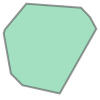

In [7]:
def random_polygon(
    radius_mean: float = 2,
    radius_sigma: float = 1.5,
):
    """Generates the simplest of polygons, a triangle with a size described by a random polygon.

    Args:
        radius_mean: The average radius defining a circumcircle of a triangle.
        radius_sigma: The variance of a radius defining a circumcircle of a triangle.

    Returns:
        A single triangle.
    """
    # define the number of corners
    number_of_corners = np.random.randint(3, 10)
    
    # generate carthesion coordinates from a radius and a sorted list of perigons.
    array = polar_to_cartesian(
        np.random.lognormal(radius_mean, radius_sigma),
        np.sort(np.random.rand(number_of_corners)),
    )
    
    # add an offset
    offset = np.random.randint(low=-SIZE_ROUTE, high=SIZE_ROUTE, size=(2,))
    return_values = np.zeros((number_of_corners, 2), dtype=float)
    
    return_values[:] = offset
    return_values[:, :] += np.array((np.real(array), np.imag(array))).T
    return Polygon(return_values)


np.random.seed(42)
random_polygon()

### Parameter zum generieren der Karte

Die Folgenden Paramter wurden für das Generieren von Karten genutzt:
* `radius_mean = 2` 
* `radius_sigma = 1`
* `number_of_polygons = 40`

In [8]:
def generate_obstacles(
    seed: Optional[int] = None,
    number_of_polygons: int = 40,
    radius_mean: float = 2,
    radius_sigma: float = 1,
) -> dict[str, Polygon]:
    """Generates a set of obstacles from a union of triangles.

    The union of triangles meas that if polygons overlap o polygon containing the union of those polygons is returned.
    Args:
        seed: A seed to generate a set of obstacles from.
        number_of_polygons: The number of polygons that should be drawn.
        radius_mean: The average radius defining a circumcircle of an obstacle triangle.
        radius_sigma: The variance of a radius defining a circumcircle of an obstacle triangle.

    Returns:
        A list of unified obstacles.
    """
    # sets a seed
    if seed is not None:
        np.random.seed(seed)
        
    # generate a list of poligons
    polygons = []
    for _ in range(number_of_polygons):
        poly = random_polygon(radius_mean, radius_sigma)
        # skip polygons that are to close to the startint point P(0, 0)
        if poly.contains(Point(0, 0)):
            continue
        if poly.exterior.distance(Point(0, 0)) < 1:
            continue
        # append to polygon list
        polygons.append(poly)
    
    # build unions of all polygons
    polygon_list = list(unary_union(polygons).geoms)
    return {str(i): p for i, p in enumerate(polygon_list)}

### Generieren des Zieles

Zu jedem Scenario gehört neben einer Situation auch ein Ziel. Auch zum generieren eine Ziels wurde zu erste der gleiche seed gesetzt wie für den Karten Generator. Danch wird eine zufällige Position mit Abstand zum Kartenrand ausgewählt.
Die so generierte Zielposition wird danach auf Plausibilität überprüft. Folgende Prüfungen finden Statt:
1. Es wird sichergestellt dass, das Ziel nicht in oder an einem Hinderniss liegt.
1. Eine Minimaldistanz in x und y wird sichergestellt. Leider ist hier ein Fehler passiert. Anstelle die Summe der Absoluten Distanz zu Prüfen wurden die Distanzen einzelned geprüft was verhindert das Ziele über, unter und neben dem Startpunkt gefunden werden können. Zielpunkte werden nur auf den Diagonallen gefunden. Lieder ist dies erst aufgefallen als schon zu viel Zeit vergangen war und die Daten nicht neu generiert werden konnten. Dies sollte aber zumindes das Konzept dieser KI nicht beinflussen. Wohl aber ihre direkte anwendbarkeit.

In [9]:
def generate_destination(
    obstacles: dict[str, Polygon],
    seed: Optional[int] = None,
) -> Point:
    """Generates for a map.

    Can be used to generate a valid destination for list of obstacles.
    Args:
        obstacles: A list of obstacles.
        seed: The seed determining the point.

    Returns:
        A goal that should be reached by the ship.
    """
    # sets the seed
    if seed is not None:
        np.random.seed(seed)

    # generates the point
    point: Optional[Point] = None
    while (
        point is None
        or abs(point.x) < MIN_DESTINATION_DISTANCE
        or abs(point.y) < MIN_DESTINATION_DISTANCE
        or any(obstacle.contains(point) for obstacle in obstacles.values())
    ):
        point = Point(np.random.randint(-SIZE_INNER, SIZE_INNER, size=(2,), dtype=int))
    return point


print(generate_destination(generate_obstacles(42), 42))

POINT (-61 31)


### Ploten der Situation

All die Scenarien die Oben generiert wurden sind rein Matematische Constructe und daher für den Menschenen schwer nachzufolziehen. Die Folgende Funktion übernimmt das Ploten der mit der oberen Funktion erstellten Situationen. Eine Route kann optional mit eingetragen werden.

In [10]:
def plot_situation(
    obstacles: dict[str, Polygon],
    destination: Point,
    obstacle_color: str | None = "RED",
    route = None,
    legend: bool = True,
    title: str | None = None,
) -> None:
    """PLots the obstacles into a matplotlib plot.

    Args:
        obstacles: A list of obstacles.
        destination: The destination that should be reached by the boat.
        obstacle_color: The color the obstacles should have. Can be None.
        If none all obstacles will have different colors.
        route: The route that should be plotted.
        legend: If true plots a legend.
        title: The title of the plot.
    Returns:
        None
    """
    # Create an plot in the definined size
    plt.axis([-SIZE_ROUTE, SIZE_ROUTE, -SIZE_ROUTE, SIZE_ROUTE])

    # Sets a title if one is demanded
    if title:
        plt.title(title)

    # Plots the obstacles.
    if obstacles:
        for polygon in obstacles.values():
            if obstacle_color is not None:
                plt.fill(*polygon.exterior.xy, color=obstacle_color, label="Obstacle")
            else:
                plt.fill(*polygon.exterior.xy)

    # Plots the wind direction
    # The following code for an arrow was taken modeled after:
    # https://www.geeksforgeeks.org/matplotlib-pyplot-arrow-in-python/
    plt.arrow(
        0,
        +int(SIZE_ROUTE * 0.9),
        0,
        -int(SIZE_ROUTE * 0.1),
        head_width=10,
        width=4,
        label="Wind (3Bft)",
    )

    if route is not None:
        if isinstance(route, np.ndarray):
            plt.plot(route[:, 0], route[:, 1], color="BLUE", marker=".")
        else:
            if isinstance(route, TimingFrame):
                plt.plot(route.points[:, 0], route.points[:, 1], color="BLUE", marker=".")
            else:
                raise TypeError()

    # Plots the estimation
    if destination:
        plt.scatter(*destination.xy, marker="X", color="green", label="Destination")
    plt.scatter(0, 0, marker="o", color="green", label="Start")

    if legend:
        # https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
    return None

Die aus den Seeds 0 - 11 generierten Karten werden unten Angezeigt um Beispiele der von der KI zu Lösenden Scenarien zu zeigen.
Wird dieses Notebook im Pyrate Docker Container ausgeführt werden auch die Routen eingezeichnet.

  0%|          | 0/12 [00:00<?, ?it/s]

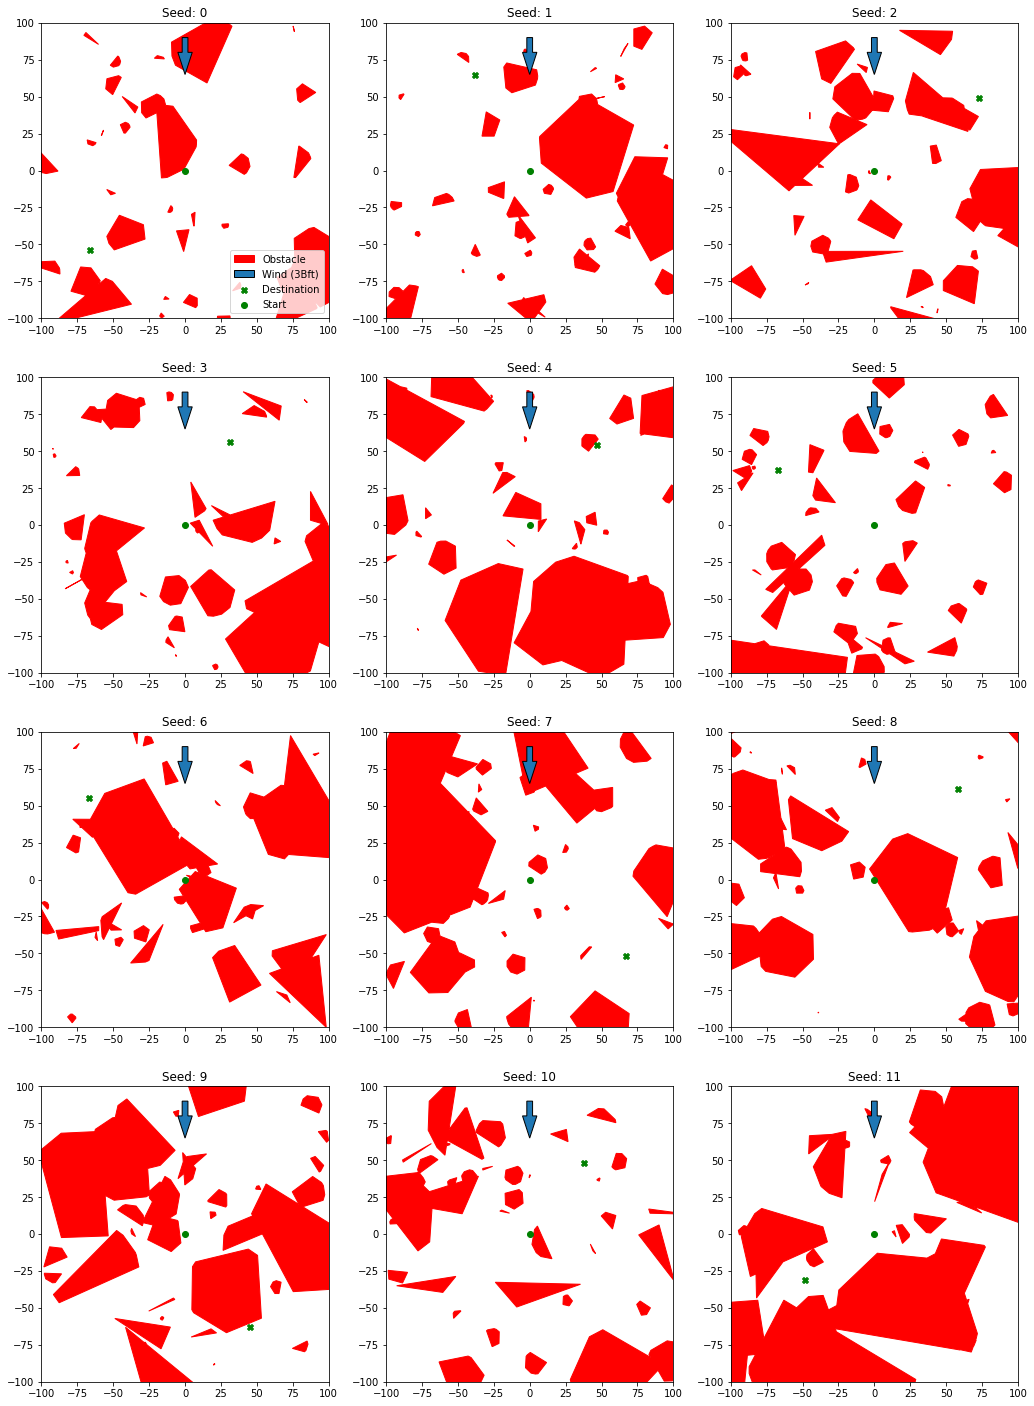

In [11]:
if not NO_SHOW:
    # create a subplot with 12 routes.
    plt.figure(figsize=(17.5, 25))
    for seed in tqdm(range(12)):
        plt.subplot(4, 3, seed + 1)
        generated_obstacles = generate_obstacles(seed)
        generated_destination = generate_destination(generated_obstacles, seed)
        route_generated = None

        # try to generate a route
        try:
            route_generated, _ = experiments.generate_route(
                position=Point(0, 0),
                goal=generated_destination,
                obstacles=generated_obstacles,
                wind=(18, 180),
            )
        except Exception:
            route_generated = None
        
        # plot the situation
        plot_situation(
            obstacles=generated_obstacles,
            destination=generated_destination,
            obstacle_color="RED",
            route=route_generated,
            title=f"Seed: {seed}, Cost: {route_generated.cost:.3f}" if route_generated else f"Seed: {seed}",
            legend=seed == 0,
        )
    plt.show()

### Das Normieren der Scenarios

Um für eine Neuronales netzt Verständlich zu sein ist es immer einfacher wenn ein Input normeirt ist. Hier wurde sich entschieden die Scenarien als Bilddaten zu normieren. 128 x 128 Pixel sind wesentlich gleichförmiger als eine Mänge von maximal 40 Polygonen mit unterschiedlichen Formen. Daher verwandelt die folgende Funktion die mit den Oben definierten Funktionen genierten Scenarien Datensätze in eine Bildform. Rot ist dabei das Hinderniss. Grün das Ziel und Blau die Route. Entwender als Linie oder als Punkt wenn die Route sich ändert.
Für diesen code wurde sich am folgenden Beispiel orientiert. https://programtalk.com/python-examples/PIL.ImageDraw.Draw.polygon/

In [12]:
def generate_image_from_map(
    obstacles: dict[str, Polygon],
    destination: Point,
    route = None,
    route_type: Literal["line", "dot"] = "dot",
) -> Image:
    """Generate an image from the map.

    Can be used to feed an ANN.
    - Obstacles are marked as reed.
    - The destination is marked as green.
    - The points where the route will likely change are blue.

    Args:
        obstacles: A dict of obstacles as shapely Polygons. Keyed as a string.
        destination: A destination that should be navigated to.
        route: The calculated route that should be followed.
        route_type: How the route is drawn. If 'line' is selected the complete route is selected.
            If 'dot' is selected the turning points a drawn in.
    """
    # generate an empty image (All black)
    img = Image.new(
        "RGB",
        (IMG_SIZE, IMG_SIZE),
        "#000000",
    )
    draw = ImageDraw.Draw(img)
    
    # draw in all obsticles in red
    for polygon in obstacles.values():
        draw.polygon(
            list(
                (np.dstack(polygon.exterior.xy).reshape((-1)) + SIZE_ROUTE)
                / (2 * SIZE_ROUTE)
                * IMG_SIZE
            ),
            fill="#FF0000",
            outline="#FF0000",
        )
        
    # draw in a route if possible. Does so in blue
    if os.getenv("PYRATE"):
        if isinstance(route, TimingFrame):
            route = route.points
    if route is not None:
        route = ((route + SIZE_ROUTE) / (2 * SIZE_ROUTE) * IMG_SIZE).astype(int)
        # draws the route as collection of lines
        if route_type == "line":
            draw.line([tuple(point) for point in route], fill=(0, 0, 0xFF))
        # draw the route as a collection of points. The starting point is seen as redundent ad left out
        elif route_type == "dot":
            for point in route[1:]:
                img.putpixel(point, (0, 0, 0xFF))
        else:
            raise ValueError("Route type unknown.")
    # draws in the destination in green
    img.putpixel(
        (
            int((destination.x + SIZE_ROUTE) / (2 * SIZE_ROUTE) * IMG_SIZE),
            int((destination.y + SIZE_ROUTE) / (2 * SIZE_ROUTE) * IMG_SIZE),
        ),
        (0, 0xFF, 0),
    )
    return img

In [13]:
def generate_example_image(route_type: Literal["line", "dot"]):
    """
    Generates an example image with the seed 42.

    Args:
        route_type: How the route is drawn. If 'line' is selected the complete route is selected.
            If 'dot' is selected the turning points a drawn in.

    Returns:
        The example image.
    """
    # generate obstacles and a destination
    obstacles = generate_obstacles(42)
    destination = generate_destination(obstacles, 42)
    # try to generate a route
    try:
        route, _ = experiments.generate_route(
            position=Point(0, 0),
            goal=destination,
            obstacles=obstacles,
            wind=(18, 180),
        )
    except Exception:
        route = None
        
    # draw the scenario
    return generate_image_from_map(
        obstacles=obstacles,
        destination=destination,
        route=route,
        route_type=route_type,
    )

Nachfolgend werden zwei solcher Scenarien Bilder gezeigt. Zerst aber wird zum Vergleich das Scenario mit dem Seed 42 als Karte Dargestellt um den Unterschied zu zeigen.

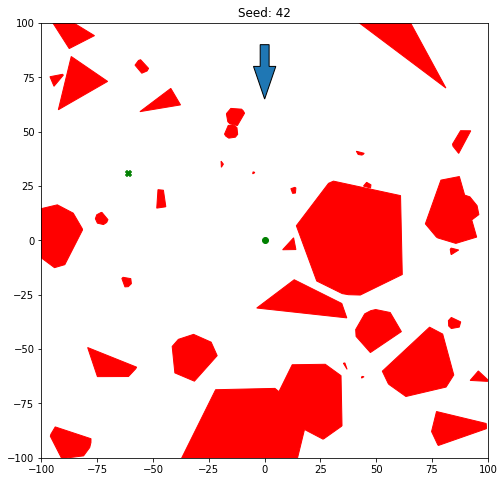

In [14]:
if not NO_SHOW:
    # set the default seed of 42
    seed: int = 42
    # create a figure
    plt.figure(figsize=(8, 8))
    wind_dir = 180
    # generate obstacles and a destination
    generated_obstacles = generate_obstacles(seed)
    generated_destination = generate_destination(generated_obstacles, seed)
    route_generated = None
    # try generating a route
    try:
        route_generated, _ = experiments.generate_route(
            position=Point(0, 0),
            goal=generated_destination,
            obstacles=generated_obstacles,
            wind=(18, wind_dir),
        )
    except Exception as e:
        route_generated = None
    # ploting the situation
    plot_situation(
        obstacles=generated_obstacles,
        destination=generated_destination,
        obstacle_color="RED",
        route=route_generated,
        title=f"Seed: {seed}, Cost: {route_generated.cost:.3f}" if route_generated else f"Seed: {seed}",
        legend=seed == 0,
    )
    plt.show()

Zeigt das Scenario mit dem Seed 42 mit eingezeichneten Wendepunkten wenn dieses Notebook im Pyrate Docker Container ausgeführt wurde. Wichtig zu beachten ist in dieser Darstellung die Drehung des Vorzeichens der Y Achse was zu einer Horizontalen Spiegelung der Darstellung führt.

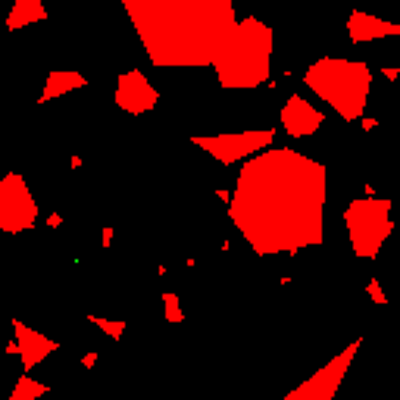

In [15]:
generate_example_image(route_type="dot").resize(
    (IMG_SHOW_SIZE, IMG_SHOW_SIZE), Image.Resampling.BICUBIC
)

Zeigt dads Scenario mit dem Seed 42 mit eingezichneten Wendepunkten wenn dieses Notebook im Pyrate Docker Container ausgeführt wurde.

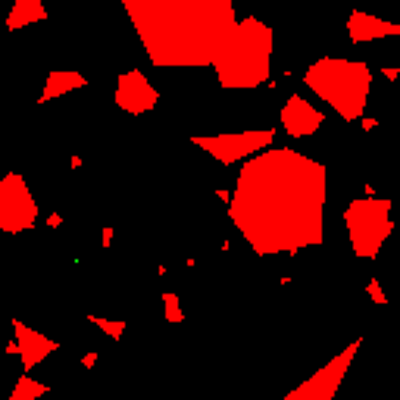

In [16]:
generate_example_image(route_type="line").resize(
    (IMG_SHOW_SIZE, IMG_SHOW_SIZE), Image.Resampling.BICUBIC
)

### Massengenerierung von Daten

Die oben definierten Funktionen generieren immer einen Datensatze.
Die folgenden Funktionen definieren einen einzu einen einzelnen Datensatz als `pd.Series` eriner einzelnen Zeile in einem `pd.DataFrame`. Die so erzeugten Datensatze wereden in `pd.DataFrames` zusammengefasst. Hier wurde eine Anzahl von 50 Datensaätzen auf einmal gewählt. Diese werden dann gespeichert um danach mehr Daten zu Generieren. Da der Wegfindealgorihmus immernoch experimentel ist werden Wege die nicht gefunden werden oder bei deren finden ein Fehler auftritt werden mit `NaN` gefüllt.

In [17]:
def generate_all_to_series(
    seed: Optional[int] = None, image: bool = False
) -> pd.Series:
    """Generates everything and aggregates all data into a `pd:Series`.

    Args:
        seed:The seed that should be used to generate map and destination.
        image: If an image should be generated or if that should be postponed to save memory.
    Returns:
        Contains a `pd.Series`containing the following.
        - The seed tha generated the map.
        - The destination in x
        - The destination in y
        - A list of Obstacle polygons.
        - The route generated for this map by the roBOOTer navigation system.
        - Optionally the image containing all the information.
          Can be generated at a later date without the fear for a loss of accuracy.
    """
    # generate obstacles
    obstacles = generate_obstacles(seed)
    # find a destination
    destination = generate_destination(obstacles, seed)
    
    # find a possible route
    try:
        route, _ = experiments.generate_route(
            position=Point(0, 0),
            goal=destination,
            obstacles=obstacles,
            wind=(18, wind_dir),
        )
    except Exception:
        route = None
    
    # collect all generated data in a `pd.Series`
    return pd.Series(
        data={
            "seed": str(seed),
            "obstacles": obstacles,
            "destination_x": destination.x,
            "destination_y": destination.y,
            "image": generate_image_from_map(obstacles, destination, route)
            if image
            else pd.NA,
            "route": route.points if route else pd.NA,
            "cost": route.cost if route else pd.NA,
        },
        name=str(seed),
    )

Nachfolgend wird ein kurzes Beispiel eines solchen `pd.DataFrame` angezeigt.

In [18]:
df = None
if not NO_SHOW:
    df = pd.DataFrame(
        [generate_all_to_series(i, image=False) for i in tqdm(range(12))]
    ).set_index("seed")
    df.to_pickle("test.pickle")
if os.path.exists("test.pickle"):
    df = pd.read_pickle("test.pickle")
else: 
    print("No data generated or chached!")
df

  0%|          | 0/12 [00:00<?, ?it/s]

obstacles  destination_x  \
seed                                                                     
0     {'0': POLYGON ((-17.62168766659423 -98.3692662...          -66.0   
1     {'0': POLYGON ((-97.82715137072381 -82.2211677...          -38.0   
2     {'0': POLYGON ((-46.23706006792075 -76.7569948...           73.0   
3     {'0': POLYGON ((-7.4210414351932155 -83.111096...           31.0   
4     {'0': POLYGON ((-77.97638439917915 -70.2390972...           47.0   
5     {'0': POLYGON ((-71.45682729091783 -138.627922...          -67.0   
6     {'0': POLYGON ((-76.20025009472265 -92.9434076...          -67.0   
7     {'0': POLYGON ((10.806865516434499 -102.670968...           67.0   
8     {'0': POLYGON ((-38.740101054728726 -89.986420...           58.0   
9     {'0': POLYGON ((-28.332925461055822 -73.516031...           45.0   
10    {'0': POLYGON ((-42.90670292182745 -82.5864109...           38.0   
11    {'0': POLYGON ((-124.01583316741481 -73.449792...          -48.0   

      destination_y image route  cost  
seed                                   
0             -54.0  <NA>  <NA>  <NA>  
1              65.0  <NA>  <NA>  <NA>  
2              49.0  <NA>  <NA>  <NA>  
3              56.0  <NA>  <NA>  <NA>  
4              54.0  <NA>  <NA>  <NA>  
5              37.0  <NA>  <NA>  <NA>  
6              55.0  <NA>  <NA>  <NA>  
7             -52.0  <NA>  <NA>  <NA>  
8              61.0  <NA>  <NA>  <NA>  
9             -63.0  <NA>  <NA>  <NA>  
10             48.0  <NA>  <NA>  <NA>  
11            -31.0  <NA>  <NA>  <NA>

Die Folgende Zelle ist Verantwortlich für das massenweise Generieren von Trainingsdaten. Sie kann entwender so eingestellt werden das nur eine einzige Batch aus 50 neuen Datensätzen generiert werden soll oder eine ganze Reihe von Batches. Sind nicht alle anforderungen zun Ausführen der Zelle erfüllt wird sie automatische übersprunngen.

In [19]:
# Skipps the following cell if the code can't be executed.
if os.getenv("PYRATE"):
    save_frequency = int(os.getenv("save_frequency", "50"))
    start_seed = int(os.getenv("seed_start", "0"))
    continues = bool(os.getenv("continues", "false"))
    
    # try finding a block of seeds that is not used
    files = glob.glob("data/*.pickle")
    seed_groups = {int(file[9:-7]) for file in files}
    for next_seeds in range(start_seed, 1_000_000, save_frequency):
        # skip if the seed block already exists or is generated by another instance if this notebook
        if next_seeds in seed_groups:
            continue
            
        # start generating routes for the seed block
        print(f"Start generating routes for seed: {next_seeds}")
        
        # reserving the seed block by looking down the seed block with an empty file
        tmp_pickle_str: str = f"data/tmp_{next_seeds:010}.pickle"
        pd.DataFrame().to_pickle(tmp_pickle_str)
        
        # generate the data
        df = pd.DataFrame(
            [
                generate_all_to_series(i, image=False)
                for i in tqdm(range(next_seeds, next_seeds + save_frequency, 1))
            ]
        ).set_index("seed")
        
        # saves the data and delete the temporary file
        pickle_to_file = f"data/raw_{next_seeds:010}.pickle"
        df.to_pickle(pickle_to_file)
        os.remove(tmp_pickle_str)
        
        # break the loop if only a single block of data should be generated.
        if not continues:
            break

### Daten Zusammenfassen

Nachdem man den Generierenden Teil des Codes für eine Weile hat laufen lassen erhällt man eine vielzahl einzelner Dateine. Diese werden Nachfolgend Zusammengefasst. Diese so zusammengefasste Tabelle wird nachfolgend bereinigt.
Direkt nach dem Zusammenfassen der Daten werden alle einträge für die keine Routen gefunden wurde weggelassen.

Dies kann folgende Gründe haben:
* Startpunkt $P(0, 0)$ ist von Hindernissen eingeschlossen
* Der Zielpunkt ist von Hindernissen eingeschlossen
* Fehler im Algorithmus der die Routen generiert

In [20]:
DATA_COLLECTION_PATH: Final[str] = "data/collected.pickle"

# Load a cached result should it not be demanded to generate all data new.
if os.path.exists(DATA_COLLECTION_PATH) and not GENERATE_NEW:
    collected_data = pd.read_pickle(DATA_COLLECTION_PATH)
else:
    # Read the first n files
    # The number of files read can be defined with the constant: NUMBER_OF_FILES_LIMIT
    # The dataframes read are concatinated direclty after
    collected_data = pd.concat(
        [
            pd.read_pickle(filename)
            for filename in tqdm(glob.glob("data/raw_*.pickle")[:NUMBER_OF_FILES_LIMIT])
        ]
    )
# Prints a short summary of the data.
number_of_maps = len(collected_data.index)
print(f"{number_of_maps: 8} maps collected")
collected_data.dropna(subset=["route"], inplace=True)
number_of_routes = len(collected_data.index)
print(f"{number_of_routes: 8} routes collected")
collected_data.to_pickle(DATA_COLLECTION_PATH)
collected_data

  0%|          | 0/1000 [00:00<?, ?it/s]

   50000 maps collected
   43400 routes collected


obstacles  destination_x  \
seed                                                                      
0      {'0': POLYGON ((-17.62168766659423 -98.3692662...          -66.0   
1      {'0': POLYGON ((-97.82715137072381 -82.2211677...          -38.0   
2      {'0': POLYGON ((-46.23706006792075 -76.7569948...           73.0   
3      {'0': POLYGON ((-7.4210414351932155 -83.111096...           31.0   
4      {'0': POLYGON ((-77.97638439917915 -70.2390972...           47.0   
...                                                  ...            ...   
50045  {'0': POLYGON ((-86.63193290264695 -93.5319244...           69.0   
50046  {'0': POLYGON ((2.518895755683328 -96.87282498...          -71.0   
50047  {'0': POLYGON ((-4.460598846031621 -99.2649725...          -36.0   
50048  {'0': POLYGON ((-90.6998307775452 -75.58510795...          -48.0   
50049  {'0': POLYGON ((-73.30908588454162 -74.1477834...          -48.0   

       destination_y image                                              route  \
seed                                                                            
0              -54.0  <NA>  [[0.0, 0.0], [-6.514627334268863, -5.502693040...   
1               65.0  <NA>                        [[0.0, 0.0], [-38.0, 65.0]]   
2               49.0  <NA>  [[0.0, 0.0], [43.20648551245758, 31.2114102262...   
3               56.0  <NA>  [[0.0, 0.0], [5.303962239032221, 10.6856391688...   
4               54.0  <NA>  [[0.0, 0.0], [4.691900284503645, -5.4114328014...   
...              ...   ...                                                ...   
50045          -61.0  <NA>  [[0.0, 0.0], [-9.17985022292322, 0.74185570341...   
50046          -58.0  <NA>  [[0.0, 0.0], [-54.61671323674942, -33.84002165...   
50047          -47.0  <NA>                       [[0.0, 0.0], [-36.0, -47.0]]   
50048          -42.0  <NA>                       [[0.0, 0.0], [-48.0, -42.0]]   
50049           72.0  <NA>  [[0.0, 0.0], [-8.34785332097252, 2.56320973960...   

               cost  
seed                 
0        100.151629  
1      75292.761936  
2      18967.522925  
3      63200.630758  
4      28914.654143  
...             ...  
50045     695.38234  
50046     67.928607  
50047     36.544878  
50048     37.990761  
50049  34269.035908  

[43400 rows x 6 columns]

### Daten Filtern

Die so erzeugten Daten sind ungefiltert. Sie müssen nun überprüft werden. Dazu wurden einige hundert Datensätze Geplottet. Einige Musster sind dabei Aufgefallen. Die Nachfolgenden Filter resultieren aus diesen Mustern.

#### Die Route Verlässt die Karte

Das Generieren von Heatmaps von Segelrouten erfordert das sich das mögliche Ergebniss sinvoll darstellen lässt. Dazu muss die Route vollständig im definierten Bereich liegen. Alle Routen die die Karte verlassen werden weggelassen.

In [21]:
def check_route_in_bounds(route):
    """
    Check if a route exists and is in bounds.
    
    Args:
        route: An `np.ndarray` of points the builds the route.
        
    Returns:
        A non existing route or a route that leaves the area routes should stick to return `False`.
        Otherwise `True` is returned.
    """


    # CHecks if the route exists
    if route is None:
        return False
    if route is pd.NA:
        return False
    # Checks if the route is of the right dtype.
    if not isinstance(route, np.ndarray):
        return False
    # Checks if a possition is out of bounds.
    if np.array(
        abs(route) > SIZE_ROUTE,
    ).any():
        return False
    return True

# Count the number of datapoints there are before this filter is used.
data_before = len(collected_data.index)

# Filtering
df_filter = collected_data["route"].apply(check_route_in_bounds)
filtered = collected_data[~df_filter]
collected_data = collected_data[df_filter]

# Count the number of datapoints there are after this filter is used.
data_after = len(collected_data.index)

# Print a short report over the changes to the dataset.
print(
    f"{data_before} - {data_before-data_after} = {data_after} sets of data remaining."
)

# delete variables that where only used inside this cell
del data_before, data_after, filtered, df_filter

43400 - 188 = 43212 sets of data remaining.


#### Routen auf Fehler überprüfen

Ein bug in der Routenfindung hat zu selbstschneidung der Routen gefürt dieser wurde beim Sailing Team Darmstadt e.V. behoben. In den ersten ca. 27000 datensätzen gibt es denoch Selbstschneidungen der Routen. Diese werden hier erkannt und da nicht Representativ und nicht Richtig aus diesem Datensatz herausgenommen.

In [22]:
def check_route_self_crossing(route):
    """
    Check if a route has self intersections.
    
    Args:
        route: An `np.ndarray` of points the builds the route.
        
    Returns:
        `True` if the route is self ingtersecting.
    """
    if isinstance(route, float):
        print(float)
    return not LineString(route).is_simple

# count the number of datapoints before this filter was applied.
data_before = len(collected_data.index)

# filter the data
collected_data = collected_data[
    ~collected_data["route"].apply(check_route_self_crossing)
]

# count the number of datapoints after this fitler was applied.
data_after = len(collected_data.index)

# print a short report over the changes to the dataset.
print(
    f"{data_before} - {data_before-data_after} = {data_after} sets of data remaining."
)

# delete variables that where only used inside this cell
del data_before, data_after

43212 - 2759 = 40453 sets of data remaining.


#### Filter der Routen nach Kosten

Einige der Routen haben trotz einer Erfolgreichen wegfindung enorm Hohe kosten. Kosten werden beim Generieren der route mitberechnet und sind was bei dem Routengenerierenden Grandientenabstigsverfahren optimiert werden. Sie setzen sich zusammen aus Segelzeit und Risiken. Auserordentlich Hohe Kosten legen daher entwender nahe das keine gute Route gefunden werden konnte oder das die gefundene Route zu einem Schlechten Lokalen Minimum convergiert hat. Daher werden die teuersten $5\%$ der Routen weggelassen.

Die folgende Route berechnet das $95\%$ Quantil und errechnet wie viele Einträge über $95\%$ liegen.

In [23]:
QUANTILE_LIMIT: Final[float] = 0.95
if "DATA_UPPER_LIMIT_QUANTIL" not in locals():
    DATA_UPPER_LIMIT_QUANTIL: Final[float] = collected_data["cost"].quantile(
        QUANTILE_LIMIT
    )
    OVER_QUANTILE: Final[int] = int(len(collected_data.index) * (1 - QUANTILE_LIMIT))
print(
    f"{OVER_QUANTILE} entries over the {QUANTILE_LIMIT} quantile at {DATA_UPPER_LIMIT_QUANTIL:.3f}"
)

2022 entries over the 0.95 quantile at 39839.307


Der folgende Codeshnippsel berechnet das Histogramm der Kosten. Wie wenig die höchsten $5\%$ der Kosten representativ sind ist direkt ersichtlich.

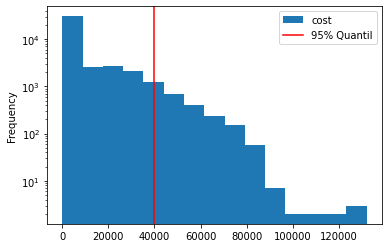

In [24]:
collected_data["cost"].plot.hist(bins=15, log=True)
plt.axvline(x=DATA_UPPER_LIMIT_QUANTIL, color="RED", label="95% Quantil")
plt.legend()
plt.show()

Nochfolgend werden einige der Route mit sehr hohenn Kosten gezeigt. Die Meisten kommen dem Land sehr nahe oder Segeln sehr stark gegen den Wind.

  0%|          | 0/12 [00:00<?, ?it/s]

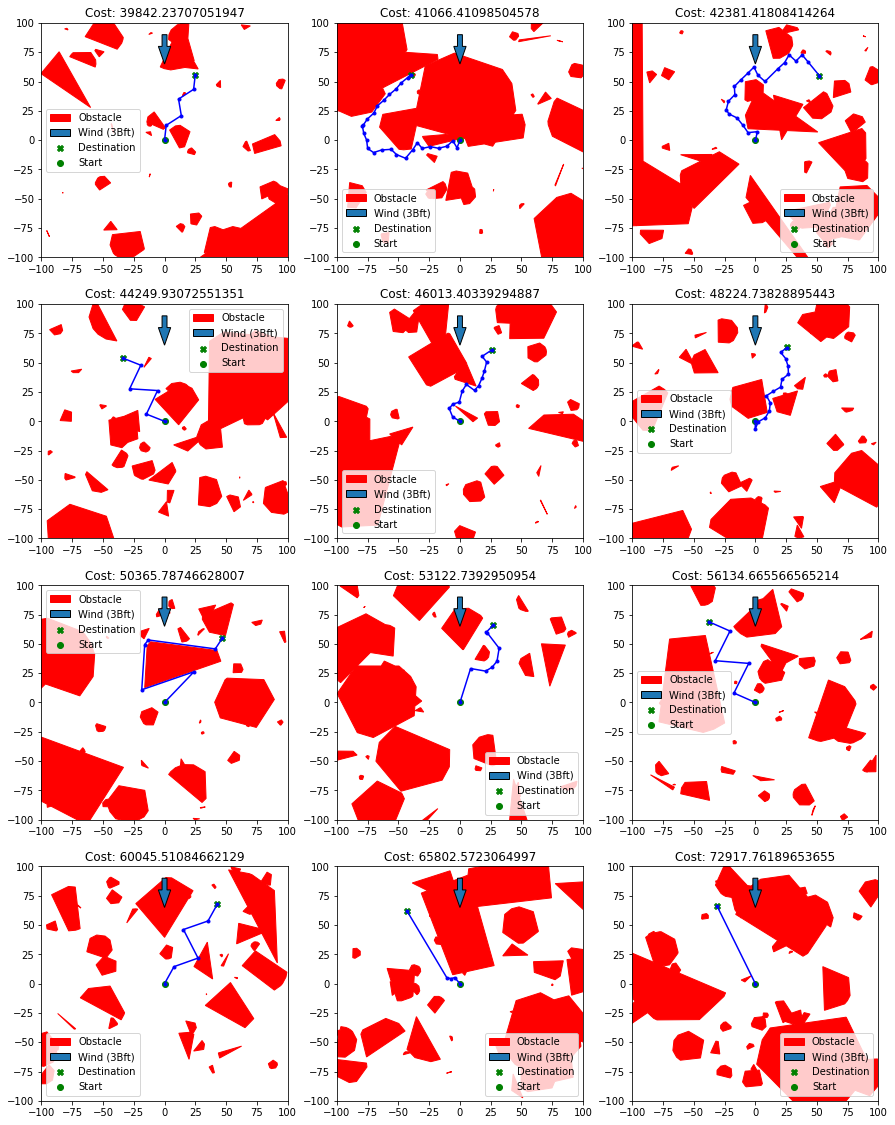

In [25]:
plt.figure(figsize=(15, 25))
for count, (seed, row) in tqdm(
    enumerate(
        collected_data[collected_data["cost"] > DATA_UPPER_LIMIT_QUANTIL]
        .sort_values("cost")
        .iloc[0 :: int(OVER_QUANTILE / 12)]
        .iloc[:12]
        .iterrows()
    ),
    total=12,
):
    plt.subplot(5, 3, count + 1)
    plot_situation(
        destination=Point(row.destination_x, row.destination_y),
        obstacles=row.obstacles,
        obstacle_color="RED",
        route=row.route,
        title=f"Cost: {row.cost}",
    )
plt.show()

Die Daten werden nun beim $95\%$ Quantil der Kosten gefiltert.

In [26]:
collected_data = collected_data.loc[collected_data["cost"] < DATA_UPPER_LIMIT_QUANTIL]
collected_data

obstacles  destination_x  \
seed                                                                      
0      {'0': POLYGON ((-17.62168766659423 -98.3692662...          -66.0   
2      {'0': POLYGON ((-46.23706006792075 -76.7569948...           73.0   
4      {'0': POLYGON ((-77.97638439917915 -70.2390972...           47.0   
5      {'0': POLYGON ((-71.45682729091783 -138.627922...          -67.0   
6      {'0': POLYGON ((-76.20025009472265 -92.9434076...          -67.0   
...                                                  ...            ...   
50045  {'0': POLYGON ((-86.63193290264695 -93.5319244...           69.0   
50046  {'0': POLYGON ((2.518895755683328 -96.87282498...          -71.0   
50047  {'0': POLYGON ((-4.460598846031621 -99.2649725...          -36.0   
50048  {'0': POLYGON ((-90.6998307775452 -75.58510795...          -48.0   
50049  {'0': POLYGON ((-73.30908588454162 -74.1477834...          -48.0   

       destination_y image                                              route  \
seed                                                                            
0              -54.0  <NA>  [[0.0, 0.0], [-6.514627334268863, -5.502693040...   
2               49.0  <NA>  [[0.0, 0.0], [43.20648551245758, 31.2114102262...   
4               54.0  <NA>  [[0.0, 0.0], [4.691900284503645, -5.4114328014...   
5               37.0  <NA>  [[0.0, 0.0], [-42.539218405821984, 15.14880405...   
6               55.0  <NA>  [[0.0, 0.0], [-7.80975254664349, 3.41866699781...   
...              ...   ...                                                ...   
50045          -61.0  <NA>  [[0.0, 0.0], [-9.17985022292322, 0.74185570341...   
50046          -58.0  <NA>  [[0.0, 0.0], [-54.61671323674942, -33.84002165...   
50047          -47.0  <NA>                       [[0.0, 0.0], [-36.0, -47.0]]   
50048          -42.0  <NA>                       [[0.0, 0.0], [-48.0, -42.0]]   
50049           72.0  <NA>  [[0.0, 0.0], [-8.34785332097252, 2.56320973960...   

               cost  
seed                 
0        100.151629  
2      18967.522925  
4      28914.654143  
5        186.095369  
6      23898.229531  
...             ...  
50045     695.38234  
50046     67.928607  
50047     36.544878  
50048     37.990761  
50049  34269.035908  

[38430 rows x 6 columns]

Ein neues Histogramm der Kostenfunktion wird geplottet.

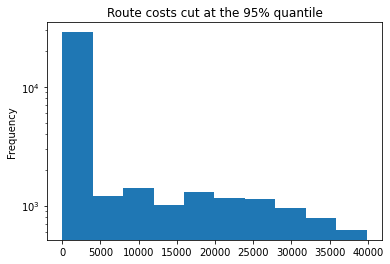

In [27]:
collected_data["cost"].plot.hist(log=True)
plt.title("Route costs cut at the 95% quantile")
plt.show()

#### Filter der Routen nach Kompläxität

Gegenüber den Routen mit zu Hohen Kosten stehen die Routen mit zu geringen Kosten. Daher werden als nächsten Routen mit zu niedrigen Kosten Betrachtet.
Nachfolgend ist eine Auswahl solcher niedrigkostiger Routen angezeigt. Es fällt auf das all diese Routen direkt sind.
Eine betrachtung der Verteilung der Routenpunkte ist daher notwendig.

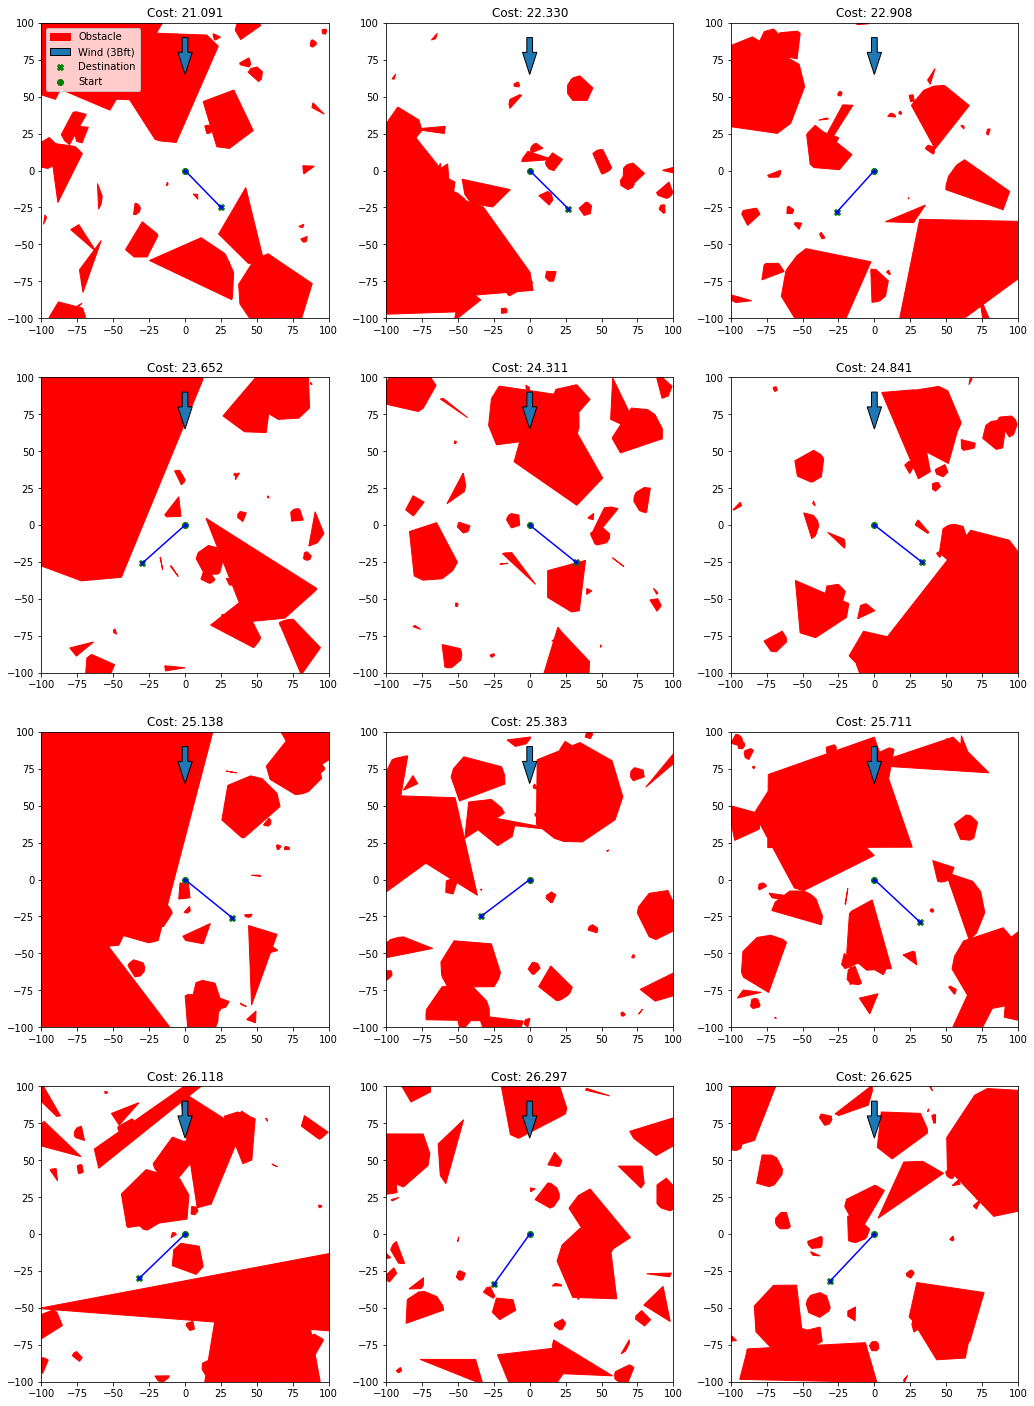

In [28]:
plt.figure(figsize=(17.5, 25))
for count, (seed, row) in enumerate(
    collected_data[collected_data["cost"] < DATA_UPPER_LIMIT_QUANTIL]
    .sort_values("cost")
    .iloc[1:600:51]
    .iterrows()
):
    plt.subplot(4, 3, count + 1)
    plot_situation(
        destination=Point(row.destination_x, row.destination_y),
        obstacles=row.obstacles,
        obstacle_color="RED",
        route=row.route,
        title=f"Cost: {row.cost:.3f}",
        legend=count == 0,
    )
plt.show()
del seed

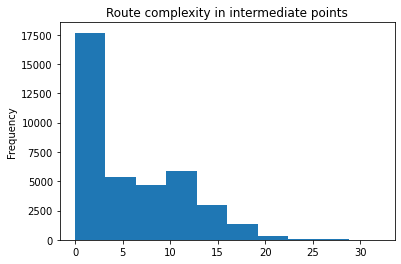

In [29]:
def get_route_points(data):
    """
    Counts how many stops are made inbetween.
    
    Args: 
        data: a `pd.DataFrame` collecting all the data.
    Returns:
        
    """
    complexity = data["route"].apply(lambda r: r.shape[0] - 2)
    complexity.name = "route complexity"
    return complexity

route_points = get_route_points(collected_data)
route_points.plot.hist()
plt.title("Route complexity in intermediate points")
plt.show()

Bei der oben angezeigten Complexität wird deutlich das diese teilweise etwas noch ist. Hier wird ein Limit von 15 eingeführt.

In [30]:
routes_before = len(collected_data.index)
collected_data = collected_data[route_points <= 15]
routes_after = len(collected_data.index)
print(
    f"{routes_before} - {routes_before - routes_after} = {routes_after} "
    f"if only routes with less then 15 course changes remain."
)

38430 - 1797 = 36633 if only routes with less then 15 course changes remain.


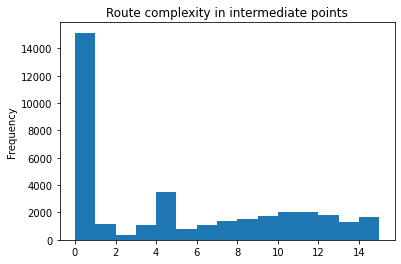

In [31]:
get_route_points(collected_data).plot.hist(bins=15)
plt.title("Route complexity in intermediate points")
plt.show()

Die nun reduzierte Anzahl der Routen enthällt eine zwar Representative mänge an sehr einfachen Routen. Da das ergebniss dieser Routen aber eine lehre Heat Map für Kursänderungen ist muss hier deutlich Reduziert werden sodas sie nur einen angegebenen anteil am Gesamtvolumen ausmachen. Dieser Anteil wurde hier auf $5\%$ gesetzt.

In [32]:
# Define the upper limit the route cann reach
LIMIT_SIMPLE_CASES = 0.05
values = get_route_points(collected_data).value_counts().sort_index()
chance_limit = (
    (len(collected_data.index) * LIMIT_SIMPLE_CASES * (1 - LIMIT_SIMPLE_CASES))
    / values.get(0, 1)
    if 0 in values.index
    else 0
)
print(
    f"Limiting simple cases to {LIMIT_SIMPLE_CASES * 100:.1f}% of the total routes. Reducing simple routes to {(chance_limit * 100):.1f}% of their volume."
)

Limiting simple cases to 5.0% of the total routes. Reducing simple routes to 11.5% of their volume.


Der folgende abschnitte setzt das oben aufgestllte limit um.

In [33]:
np.random.seed = 0
collected_data = collected_data[
    (
        (get_route_points(collected_data) > 1)
        | (np.random.random(len(collected_data.index)) < chance_limit)
    )
]
del chance_limit

Die so veränderte distribution der Routencomplexität sieht dann so aus.

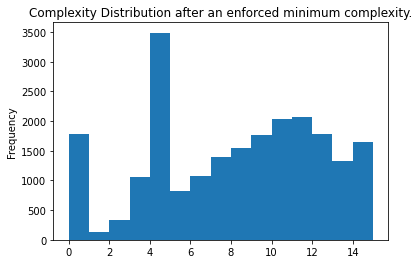

In [34]:
get_route_points(collected_data).plot.hist(bins=15)
plt.title("Complexity Distribution after an enforced minimum complexity.")
plt.show()

Das `pd.DataFrame` welches die Gefilterten Daten sammelt sieht dann wie folgt aus:

In [35]:
collected_data

obstacles  destination_x  \
seed                                                                      
0      {'0': POLYGON ((-17.62168766659423 -98.3692662...          -66.0   
2      {'0': POLYGON ((-46.23706006792075 -76.7569948...           73.0   
4      {'0': POLYGON ((-77.97638439917915 -70.2390972...           47.0   
8      {'0': POLYGON ((-38.740101054728726 -89.986420...           58.0   
12     {'0': POLYGON ((-78.64598261951151 -82.5905995...           55.0   
...                                                  ...            ...   
50034  {'0': POLYGON ((-28.196683384837495 -99.951510...          -60.0   
50039  {'0': POLYGON ((-80.21298069840438 -87.2502584...           74.0   
50043  {'0': POLYGON ((-55.5210778390028 -66.95232495...           47.0   
50044  {'0': POLYGON ((-73.9722160089151 -90.72439219...          -66.0   
50049  {'0': POLYGON ((-73.30908588454162 -74.1477834...          -48.0   

       destination_y image                                              route  \
seed                                                                            
0              -54.0  <NA>  [[0.0, 0.0], [-6.514627334268863, -5.502693040...   
2               49.0  <NA>  [[0.0, 0.0], [43.20648551245758, 31.2114102262...   
4               54.0  <NA>  [[0.0, 0.0], [4.691900284503645, -5.4114328014...   
8               61.0  <NA>  [[0.0, 0.0], [-8.211437427025228, -1.293253961...   
12             -72.0  <NA>  [[0.0, 0.0], [7.15433954975134, 5.559264844101...   
...              ...   ...                                                ...   
50034          -67.0  <NA>  [[0.0, 0.0], [-4.393689188661578, -7.847642659...   
50039           31.0  <NA>  [[0.0, 0.0], [5.67318252835214, -5.67318252835...   
50043           28.0  <NA>  [[0.0, 0.0], [3.868462226776941, 3.86846222677...   
50044           49.0  <NA>                        [[0.0, 0.0], [-66.0, 49.0]]   
50049           72.0  <NA>  [[0.0, 0.0], [-8.34785332097252, 2.56320973960...   

               cost  
seed                 
0        100.151629  
2      18967.522925  
4      28914.654143  
8      16899.906926  
12       177.415475  
...             ...  
50034    149.322187  
50039   5162.824624  
50043    284.832436  
50044    199.213594  
50049  34269.035908  

[22264 rows x 6 columns]

### Das convertieren in trainierbare Daten

Die bisher erstellten und gefilterten Daten müssen nun mit der oben definierten methode zum generieren von Bildern `generate_image_from_map` transformiert werden. Die so transformierten daten werden dann zusammengefasst und in ein `tf.Dataset` convertiert werden welches von Pandas genau für solche Fälle vorgeshen wird. Es gibt dort auch andere Methoden wie zum Beispiel die methode `tf.keras.utils.image_dataset_from_directory`. Bei diesem Problem besteht aber die Hoffnung das auch ohne Solche Methoden der RAM ausreicht und die Daten nicht immer wieder neu von der Festplatte gelesen werden müssen.

In [36]:
def generate_image_maps(row, route_type: Literal["dot", "line"]):
    """Generates the image version of the route.
    
    Adds another dimention to prepare vor concatination in a later step.
    Divides by 0xFF to contain only 0 and 1 and valus.
    Color channel zero contains obstacles.
    Color channel one contains the destination.
    Color channel two contains the route either as course change poiunts or as continues lines.
        
    Args:
        row: The row of the pd.DataFrame that shoul be used to generate an image.
        route_type: Defines if the route should be drawn as a collection of course change points or continues lines.
    Returns:
        The image modeified for concatination and sacled to be easily used for pandas.
        Cast as uint8 for a minimal memory consumption.
    """
    # expands the dimesion by one
    img = np.expand_dims(
        # converts the image into a numpy array
        np.asarray(
            # generate the situation image form a map
            generate_image_from_map(
                obstacles=row.obstacles,
                destination=Point(row.destination_x, row.destination_y),
                route=row.route,
                route_type=route_type,
            )
        ),
        axis=0,
    )
    # integer divide to ensure all values are between 0 and 1
    img = img // 0xFF
    return img

In [37]:
# drop the image column to save some space in the dataset
if "image" in collected_data.columns:
    del collected_data["image"]

In [38]:
# save the collected and filtered data into a pickle file to load again later and flush the ram a bit.
DATA_WITH_IMG_PATH: Final[str] = "data/collected_and_filtered.pickle"
collected_data.to_pickle(DATA_WITH_IMG_PATH)

In [ ]:
# collecting map images with routes as lines.
collected_routes = np.concatenate(collected_data.progress_apply(
    generate_image_maps, axis=1, args=("line",)
))

  0%|          | 0/22264 [00:00<?, ?it/s]

Die gesammtlen Daten sind relativ groß die Nachfoglede Operation zeigt an wie viel RAM dafür gerade belegt ist.

In [ ]:
humanize.naturalsize(sys.getsizeof(collected_routes))

Stellt sicher das ein Datentype verwendet der ein Minimum an Speicher verwendet.

In [ ]:
assert str(collected_routes.dtype) == "uint8", "Dtype needs to be unit8 to fit in the ram."

In [ ]:
COLLECTED_ROUTES_LINE_DUMP = "data/collected_routes_np_line.pickle"
with open(COLLECTED_ROUTES_LINE_DUMP, "wb") as f:
    pickle.dump(collected_routes, f)

Generieret die Daten für das Line format

In [ ]:
# collecting map images with routes as dots.
collected_routes_dots = np.concatenate(collected_data.progress_apply(
    generate_image_maps, axis=1, args=("dot",)
))
assert str(collected_routes_dots.dtype) == "uint8", "Dtype needs to be unit8 to fit in the ram."
COLLECTED_ROUTES_DOT_DUMP = "data/collected_routes_np_dot.pickle"
with open(COLLECTED_ROUTES_DOT_DUMP, "wb") as f:
    pickle.dump(collected_routes, f)
# löscht das collection oject. Wenn die daten neu benötigt werden können sie vom der Festplatte neu geladen werden.
del collected_routes_dots

## Das Model


Jedes neueronalle netz hat eine Bestimmte *Form* diese wird im Modell definiert. Die Form bestimmt die Anzahl der Versteckten Schichten, ob beim Training spezielle Filter wie `Dropout` oder `BatchNormalization` ferwendet werden sollen. Auch die art der Aktivierungsfunktionen wird hier Definiert.

Oft gibt es für Bestimmte Probleme schon die Eine oder adere Art von Netzwerkstrucktur/Modelstrucktur die sich als geeignet erwiesen hat. Für diese Art von Problem wo aus einem Bild eine anderes Generiert werden soll haben sich GAN netzwerke als besonder Schalgfertig erwiesen [2], [3], [4].

GAN netzwerke bestehen immer aus zwei Kompenenten einem `Generator` und einem `Discriminator` der `Generator` generiert ein Bild von einem anderen Bild. Der `Discriminator` versucht die Builder zu Unterscheide und weist so den Gernerator auf Fehler hin die durch eine Normale Lernfunktion mit einer $l_1$ oder $l_2$ norm nicht herforgehoben werden weill es für diese oft reicht wenn das Ziel ungefähr erreicht wird. Der `Discriminator` sorg also führ Klare Kontrasste und einen Saubere Farbverläufer.

Das hier betrachtete Problem erwartet nun eine Heat map. Da nicht davon auszugehen ist das die Perfekte Route driekt gefunden wurde ist ein etwas verwaschenes ergebniss eine Funktion nicht ein Problem. Daher wird hier versucht den Routenschätzer ohen `Discriminator` aufzubauen.

### Der Generator

Der `Generator` besteht ist eine Art von Autoencoder. Er nimmt das Bild Abstraiert es in einbe Sammlung von Features und generiert aus diesem Abstracten Format wieder ein Bild.
Der `Generator` besteht daher aus einer Reihe von *Downsamplern* gefolg von eben so vielen *Upsamplern*. Der Downsampler fasst jeden zweiten Pixel 3 Pixel über ein `tf.keras.layers.Conv2D` layer zusammen. Der Upsampler macht genau dies wieder Rückgänig. So wird die Bildgröße mit jedem Downsampler Layer halbiert und mit jedem Upsampler Layer wieder Verdoppelt. Dafür erhält jeder Downsampler mehr features während der Upsampler jedes mal Features verliert. Up und Downsmapler sind meist Symetrisch aufgebaut.
Wie in, sowohl dem Tensorflows Tutorial [4], als auch in dem Paxisteinstige Maschine Learning in der Sektion über GANs [2] zu lesen ist benögitgt der Downsampler eine BatchNormaliszation leaky Relu als AktivierungsFunktion im Downsampler. Relu wird für den Upsampler Verwendet.
* Relu `y = x if x >= 0 else 0`
* LeakyRelu `y = x if x >= 0 else b * x` wobei bei eine Zahl viel kleiner als 1 ist.

BetchNormalization normaliesert die Output Werte über eine Trainig Batch indem der Mean jedes Layer Ausgangs auf 0 geschoben wird und auf die Varianz 1 skaliert wird[5]. Beim Ausführen des Models wird die in der letzten Epoche festgelegte Gesamtberschiebung und Skalierung genutzt. Dies sorg zusammen mit dem DropOut Filter im Upsampler für ein Konstitenteres Lernen und Verhindert das Overfitting.
Interesannterweise erhält jedes UPsampling Layer sowohl das Vorangangene Layer als auch das Symetrische Downsampling Layer als Input.

In [ ]:
# Source: https://www.tensorflow.org/tutorials/generative/pix2pix
def downsample(filters, size, apply_batchnorm=True):
    """Create a downsample layer.
    
    A downsample layer contains:
        * tf.keras.layers.Conv2D
        * An aktivation Function
        * Optional a batchnorm
        * A activation function (LeakyRelu)
    Args:
        filters:
        size: The number of 
        apply_batchnorm: If True the Batchnor is applied. Batch norms are used by default.
    Returns:
        A sequentail model contain the keras generated layers.
    """
    
    initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(
            filters,
            size,
            strides=2,
            padding="same",
            kernel_initializer=initializer,
            use_bias=False,
        )
    )

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [ ]:
# Source: https://www.tensorflow.org/tutorials/generative/pix2pix
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0.0, 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(
            filters,
            size,
            strides=2,
            padding="same",
            kernel_initializer=initializer,
            use_bias=False,
        )
    )

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [ ]:
def model_generator():

    inputs = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, 2])

    # down_stack = [
    #    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 64, 64, 128)
    #    downsample(128, 4),  # (batch_size, 8, 8, 512)
    #    downsample(512, 4),  # (batch_size, 4, 4, 512)
    #    downsample(512, 4),  # (batch_size, 2, 2, 512)
    #    downsample(512, 4),  # (batch_size, 1, 1, 512)
    #    downsample(512, 4),  # (batch_size, 1, 1, 512)
    #    downsample(512, 4),  # (batch_size, 1, 1, 512)
    # ]
    #
    # up_stack = [
    #    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    #    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    #    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    #    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    #    upsample(128, 4),  # (batch_size, 32, 32, 512)
    #    upsample(64, 4),  # (batch_size, 64, 64, 256)
    # ]

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 64, 64, 128)
        downsample(128, 4),  # (batch_size, 8, 8, 512)
        downsample(256, 4),  # (batch_size, 4, 4, 512)
        downsample(256, 4),  # (batch_size, 2, 2, 512)
        downsample(256, 4),  # (batch_size, 1, 1, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(256, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(256, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(256, 4),  # (batch_size, 16, 16, 1024)
        upsample(128, 4),  # (batch_size, 32, 32, 512)
        upsample(64, 4),  # (batch_size, 64, 64, 256)
    ]

    initializer = tf.random_normal_initializer(0.0, 0.02)
    last = tf.keras.layers.Conv2DTranspose(
        1,
        4,
        strides=2,
        padding="same",
        kernel_initializer=initializer,
        activation="tanh",
    )  # (batch_size, 256, 256, 3)

    x = inputs

    # Down sampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Up sampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


generator = model_generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [ ]:
!pip install pydot

In [ ]:
!pip install pydotplus

In [ ]:
generator.compile(
    optimizer=tf.keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss="mean_squared_error",
    # tf.keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[
        "binary_crossentropy",
        "mean_squared_error",
        "mean_absolute_error",
    ],  # root_mean_squared_error
)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="mean_squared_error",
    min_delta=0.0005,
    patience=2,
    verbose=0,
    mode="auto",
    restore_best_weights=True,
)

tf_board = tf.keras.callbacks.TensorBoard(
    log_dir="./log_dir",
    histogram_freq=100,
    write_graph=False,
    write_images=False,
    write_steps_per_second=True,
    update_freq="epoch",
    profile_batch=(20, 40),
    embeddings_freq=0,
    embeddings_metadata=None,
)

reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="some metric", factor=0.2, patience=5, min_lr=000.1, verbose=1
)

In [ ]:
plt.figure(figsize=(17.5, 25))
np_array = np.flip(collected_routes[1, :, :, :], axis=0)

for chanel in tqdm(range(3)):
    plt.subplot(1, 4, chanel + 1)
    plt.imshow(np_array[:, :, chanel], interpolation="nearest")
plt.subplot(1, 4, 4)
plt.imshow(0x88 * np_array[:, :, 0] + 0xFF * np_array[:, :, 2], interpolation="nearest")
plt.show()

In [ ]:
collected_routes[:, :, :, :2].shape

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (collected_routes[:, :, :, :2], collected_routes[:, :, :, 2])
)
# test_dataset = tf.data.Dataset.from_tensor_slices((test_examples, test_labels))

In [ ]:
train_dataset

In [ ]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
# train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
history = generator.fit(
    train_dataset,
    epochs=20,
    batch_size=512,
    use_multiprocessing=True,
    workers=5,
    callbacks=[early_stop, tf_board],
    # tqdm_callback,
)

In [ ]:
plt.plot(history.history["loss"])

In [ ]:
collected_routes[0:1, :, :, :2].shape

In [ ]:
predicted = generator.predict(
    collected_routes[:100, :, :, :2],
    batch_size=None,
    verbose="auto",
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=3,
    use_multiprocessing=True,
)

In [ ]:
predicted.shape

In [ ]:
plt.imshow(predicted[1, :, :, 0], interpolation="nearest")
plt.show()

In [ ]:
for pos in range(5):
    plt.imshow(
        predicted[pos, :, :, 0] * 0xFF + collected_routes[pos, :, :, 0] * 20,
        interpolation="nearest",
    )
    plt.show()

In [ ]:
# tf.keras.utils.plot_model(generator)

In [ ]:
memory = sorted(
    [
        (x, sys.getsizeof(globals().get(x)))
        for x in dir()
        if not x.startswith("_") and x not in sys.modules
    ],
    key=lambda x: x[1],
    reverse=True,
)
memory = {name: humanize.naturalsize(mem) for name, mem in memory[:10]}
memory

## Ausblick
Minimaldistanz ist or verknüpft nicht and verknüpft.

## Literaturverzeichnis

[1] Jang, Hoyun and Lee, Inwon and Seo, Hyoungseock: *Effectiveness of CFRP rudder aspect ratio for scale model catamaran racing yacht test*, 2017

[2] Aurélien Géron: *Praxiseinstig Machinen Learning mit Scikit-Learn, Keras uind TensorFlow*, 2020, O.Reilly Verlag

[3] Jun-Yan Zhu: *Image-to-Image Translation with Conditional Adversarial Networks*, 2018, Available: https://arxiv.org/abs/1611.07004

[4] Tensorflow: *pix2pix: Image-to-image translation with a conditional GAN* Available: https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb Commit: df4485e052523e0f852e83cea30ad319808bd97b

[5] Keras: *Keras* Available: https://keras.io/

@article{article,
author = {Jang, Hoyun and Lee, Inwon and Seo, Hyoungseock},
year = {2017},
month = {09},
pages = {4109-4117},
title = {Effectiveness of CFRP rudder aspect ratio for scale model catamaran racing yacht test},
volume = {31},
journal = {Journal of Mechanical Science and Technology},
doi = {10.1007/s12206-017-0807-8}
}

Ich würde auch zu 1. tendieren, stimme Ihnen aber zu, dass das Thema sehr umfangreich ist. Könnte man sich nicht einen Teilbereich herauspicken? Ich verstehe nicht viel vom Segeln, daher lassen Sie mich kurz zusammenfassen, was Sie vorhaben: - Sie generieren Trainingsdaten mit dem existierenden aber langsamen GD Algorithmus. Ich nehme an, es handelt sich um lokale Routen in einem relativ kleinen Kartenausschnitt. Lässt es die Laufzeit zu, dass Sie eine große Menge an Routen berechnen. - Sie haben dann eine Karte und als Ausgabe eine Liste der Wendepunkte - Warum wollen Sie daraus eine Heatmap berechnen? Diesen Schritt habe ich noch nicht verstanden - Wenn Sie aus einer Karte eine Heatmap trainieren wollen und dafür genügend Beispiele haben, könnnten GANs hilfreich sein: https://arxiv.org/abs/1611.07004 Ich würde Ihnen raten, das Problem möglichst so zu reduzieren, dass es im Rahmen des Moduls noch handhabbar bleibt. Alles Weitere kann man sich auch für spätere Arbeiten aufbewahren. Das 2. Thema ist auch ok. Aber vielleicht nicht ganz so spannend. Ich überlasse Ihnen die Entscheidung. Freundliche Grüße Heiner Giefers